This is a jupyter notebook to get all the data from my shapefiles, group together the objects with the same label and then save the data as png images of a size 10000 x 10000 pix (which correspond to the size of my bounding boxes).

In [1]:
import geopandas as gpd
import matplotlib
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
from matplotlib.collections import PatchCollection
import fiona
from descartes.patch import PolygonPatch
import pandas as pd
import os
import numpy as np
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

# Load the box module from shapely to create box objects
from shapely.geometry import box

## Raster data library
import rasterio
import rasterio.features
import rasterio.warp
from rasterio import plot as rioplot

# to display images inline
get_ipython().magic(u'matplotlib inline')
matplotlib.use('Agg')# not sure what I used it for

# some custom files
from img_helpers import get_all_images_in_folder

## ROADS

In [2]:
# load all the shapely files related to ROADS
fp_road = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/A_RESEAU_ROUTIER/ROUTE.shp"
fp_nmrd = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/A_RESEAU_ROUTIER/ROUTE_NOMMEE.shp"
fp_prrd= "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/A_RESEAU_ROUTIER/ROUTE_PRIMAIRE.shp"
fp_scrd ="D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/A_RESEAU_ROUTIER/ROUTE_SECONDAIRE.shp"
# Read file using gpd.read_file()
data_road = gpd.read_file(fp_road)
data_nmrd =  gpd.read_file(fp_nmrd)
data_prrd = gpd.read_file(fp_prrd)
data_scrd = gpd.read_file(fp_scrd)
frames = [data_road, data_nmrd, data_prrd, data_scrd]
# make a single table with all the roads, not just a signle type
# all_roads=  pd.concat([data_road, data_nmrd, data_prrd, data_scrd],ignore_index=True ) 
all_roads = data_road

In [3]:
all_roads.head() # small demo of the roads 

,ID,PREC_PLANI,PREC_ALTI,NATURE,NUMERO,NOM_VOIE_G,NOM_VOIE_D,IMPORTANCE,CL_ADMIN,GESTION,...,CODEPOST_D,TYP_ADRES,BORNEDEB_G,BORNEDEB_D,BORNEFIN_G,BORNEFIN_D,ETAT,Z_INI,Z_FIN,geometry
0,TRONROUT0000000053091419,1.5,1.0,Route Ã 2 chaussÃ©es,NC,AV JEAN JAURES,AV JEAN JAURES,3,Autre,NC,...,21000,Classique,0,0,0,0,NR,238.6,238.6,"LINESTRING Z (853148 6692172.1 238.6, 853145.8..."
1,TRONROUT0000000052987762,1.5,1.0,Route Ã 1 chaussÃ©e,D102B,None,None,4,DÃ©partementale,21,...,21570,NR,0,0,0,0,NR,217.7,218.1,"LINESTRING Z (824698.5 6760699.3 217.7, 824709..."
2,TRONROUT0000000053188680,1.5,1.0,Route Ã 1 chaussÃ©e,NC,R DES ECOLES,R DES ECOLES,5,Autre,NC,...,21190,Classique,0,0,0,0,NR,235.8,235.6,"LINESTRING Z (834393.9 6654304 235.8, 834394.3..."
3,TRONROUT0000000053154881,1.5,1.0,Route Ã 1 chaussÃ©e,D110E,RTE DE PAGNY LA VILLE,RTE DE PAGNY LA VILLE,4,DÃ©partementale,21,...,21250,Classique,0,0,0,0,NR,179.9,179.9,"LINESTRING Z (864121.6 6664532.8 179.9, 864126..."
4,TRONROUT0000000053155590,1.5,1.0,Route Ã 1 chaussÃ©e,D34,None,None,4,DÃ©partementale,21,...,21250,NR,0,0,0,0,NR,177.9,177.9,"LINESTRING Z (863090.4 6660066.6 177.9, 863082..."


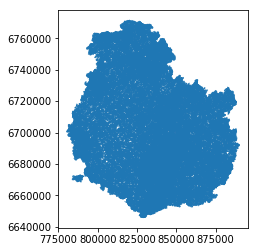

In [4]:
# we can plot all the Roads network of cote d'Or
all_roads.plot()

Data type - geographical projection of he data used.

In [5]:
all_roads.crs

{'init': 'epsg:2154'}

## Houses

In [6]:
# Load all the data from the BUILDINGS caegory
fp_bati = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/E_BATI/BATI_INDIFFERENCIE.shp"
fp_inds = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/E_BATI/BATI_INDUSTRIEL.shp"
fp_remk = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/E_BATI/BATI_REMARQUABLE.shp"
fp_ligh = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/E_BATI/CONSTRUCTION_LEGERE.shp"
# Read file using gpd.read_file()
buildings1= gpd.read_file(fp_bati)
buildings2 =gpd.read_file(fp_inds)
buildings3 = gpd.read_file(fp_remk)
buildings4 = gpd.read_file(fp_ligh)
frames = [buildings1, buildings2, buildings3, buildings4]
# concaenate the buildings into a single table
all_buildings =  pd.concat([buildings1, buildings2, buildings3, buildings4],ignore_index=True )

C:\Users\margo\Anaconda3\envs\gdal2\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [7]:
all_buildings.crs

{'init': 'epsg:2154'}

In [8]:
all_buildings.to_crs({'init': 'epsg:2154'})

,HAUTEUR,ID,NATURE,ORIGIN_BAT,PREC_ALTI,PREC_PLANI,Z_MAX,Z_MIN,geometry
0,5,BATIMENT0000000244058581,NaN,Autre,1.0,1.5,337.2,337.2,POLYGON Z ((798718.2000000319 6697368.49999807...
1,2,BATIMENT0000000052910357,NaN,Autre,1.0,1.5,351.8,350.5,POLYGON Z ((799761.400000032 6701891.899998088...
2,5,BATIMENT0000000202189149,NaN,Autre,1.0,1.5,223.4,223.4,POLYGON Z ((850351.8000000002 6676481.29999999...
3,5,BATIMENT0000000052834562,NaN,Autre,1.0,1.5,255.9,254.8,POLYGON Z ((810384.1000000349 6713006.39999811...
4,7,BATIMENT0000000052911275,NaN,Autre,1.0,1.5,294.6,294.6,POLYGON Z ((802026.2000000324 6711375.99999811...
5,4,BATIMENT0000000290868137,NaN,Autre,1.0,1.5,241.9,241.2,POLYGON Z ((808633.0000000343 6716145.19999812...
6,5,BATIMENT0000000290868135,NaN,Autre,1.0,1.5,241.9,241.0,POLYGON Z ((808643.3000000343 6716197.59999812...
7,5,BATIMENT0000000290868136,NaN,Autre,1.0,1.5,242.1,241.1,POLYGON Z ((808650.5000000343 6716175.49999812...
8,11,BATIMENT0000000052846105,NaN,Autre,1.0,1.5,200.6,200.3,POLYGON Z ((881856.2000000591 6693126.09999805...
9,3,BATIMENT0000000315425544,NaN,Autre,1.0,1.5,207.6,207.6,POLYGON Z ((869331.500000056 6678557.499998021...


## WATER 

{'init': 'epsg:2154'}

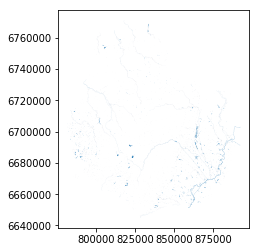

In [9]:
fp_water = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/D_HYDROGRAPHIE/SURFACE_EAU.shp"
data_water = gpd.read_file(fp_water)
data_water.plot()
data_water.crs

## SPORT TERRITORIES

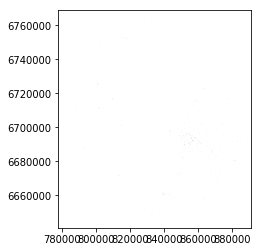

In [10]:
fp_sport = "D:/allegoria/datasets_alegoria/BD/BD_topo/cotedor/BDTOPO_2-2_TOUSTHEMES_SHP_LAMB93_D021_2018-09-25/BDTOPO/1_DONNEES_LIVRAISON_2018-11-00144/BDT_2-2_SHP_LAMB93_D021-ED182/E_BATI/TERRAIN_SPORT.shp"
data_sport = gpd.read_file(fp_sport)
data_sport.plot()

## BOUNDING BOXES FROM THE IMAGES

Finally, load the bounding boxes from all the jp2 images I have for a department

In [11]:
bb_boxes_path = 'D:/allegoria/datasets_alegoria/BD/BD_ortho/cotedor/BDORTHO_2-0_RVB-0M50_JP2-E080_LAMB93_D021_2017-01-01/BDORTHO/3_SUPPLEMENTS_LIVRAISON_2018-01-00368/BDO_RVB_0M50_JP2-E080_LAMB93_D21-2017/dalles.shp'
bb_boxes= gpd.read_file(bb_boxes_path)
bb_boxes.crs

{'init': 'epsg:2154'}

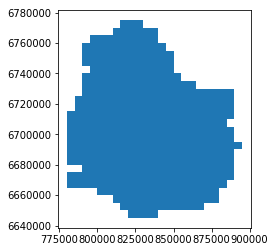

In [12]:
bb_boxes.plot()

In [13]:
bb_boxes.head()
coordinates = bb_boxes['geometry'].iat[0].exterior.coords

In [14]:
print(coordinates[0][0])
print(coordinates[1][0])
print(coordinates[2][1])
print(coordinates[0][1])

785000.0
790000.0
6715000.0
6720000.0


## IMAGES as JP2

In [12]:
folder = 'D:/allegoria/datasets_alegoria/BD/BD_ortho/cotedor/BDORTHO_2-0_RVB-0M50_JP2-E080_LAMB93_D021_2017-01-01/BDORTHO/1_DONNEES_LIVRAISON_2018-01-00368/BDO_RVB_0M50_JP2-E080_LAMB93_D21-2017'
img_type = '.jp2'
image_files = get_all_images_in_folder(folder, img_type)
name = image_files[0][-36:]
print(name)

21-2017-0780-6670-LA93-0M50-E080.jp2


## Save the shape files as .png in correspondence with given images

The function below works very slow, long to execute but the files are really huge - 10000x10000 pixels

In [80]:
plt.ioff() # don't plot anything here
save_path = 'D:/allegoria/topo_ortho/cotedor/roads/'
save_path2 = 'D:/allegoria/topo_ortho/cotedor/buildings/'
save_path3 = 'D:/allegoria/topo_ortho/cotedor/water/'
save_path4 = 'D:/allegoria/topo_ortho/cotedor/sport/'
my_dpi=300
for i in range(25): # range - number of images
    name = image_files[i][-36:]
    print(name)
    with rasterio.open(image_files[i]) as dataset:
    # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()
        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):
            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'epsg:2154', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            print(geom)

            #save image as a normal TIF
            data = dataset.read()
            kwargs = dataset.meta
            kwargs['driver'] = 'GTiff' # change this one
            kwargs['crs'] ='epsg:2154'

            with rasterio.open(('D:/allegoria/topo_ortho/cotedor/imgs_tif/'+name[1:-4]+'.tif'), 'w', **kwargs) as dst:
                    dst.write(data, indexes=(1,2,3))     

                    
        # from now on all the shape data            

        bb_box = geom['coordinates']
        polygon_bbox = Polygon(bb_box[0])

        # bounding boxes coordinates
        coordinates = bb_box[0]
        x_width, y_width =  (coordinates[2][0]-coordinates[0][0])*2, (coordinates[0][1]-coordinates[1][1])*2
        print(x_width, y_width)



        #roads
        sg_roads = all_roads[all_roads.geometry.within(polygon_bbox)] #extract segments of roads
        name_wpath = save_path + name[1:-4] + '.png'
        plt.autoscale(False)
        fig  = sg_roads.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)),linewidth=0.12, edgecolor='c')
        fig.set_xlim([coordinates[0][0],coordinates[2][0]])
        fig.set_ylim([coordinates[1][1],coordinates[0][1]])
        plt.axis('off')
        plt.autoscale(False)   
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(name_wpath, type="png", dpi= float(my_dpi) * 10)

        # buildings
        sg_houses = all_buildings[all_buildings.geometry.within(polygon_bbox)] #extract segments of buildings
        name_wpath = save_path2 + name[1:-4] + '.png'
        fig  = sg_houses.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), facecolor='c', edgecolor='c')
        fig.set_xlim([coordinates[0][0],coordinates[2][0]])
        fig.set_ylim([coordinates[1][1],coordinates[0][1]])
        plt.axis('off')
        plt.autoscale(False)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(name_wpath,type="png", dpi=float(my_dpi) * 10)

        # water
        sg_water = data_water[data_water.geometry.within(polygon_bbox)] #extract segments of water
        name_wpath = save_path3 + name[1:-4] + '.png'
        fig  = sg_water.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), facecolor='c', edgecolor='c')
        fig.set_xlim([coordinates[0][0],coordinates[2][0]])
        fig.set_ylim([coordinates[1][1],coordinates[0][1]])
        plt.axis('off')
        plt.autoscale(False)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(name_wpath,type="png", dpi=float(my_dpi) * 10)

        #sport 
        sg_sport = data_sport[data_sport.geometry.within(polygon_bbox)] #extract segments of sport  things
        name_wpath = save_path4 + name[1:-4] + '.png'
        fig  = sg_sport.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), facecolor='c', edgecolor='c')
        fig.set_xlim([coordinates[0][0],coordinates[2][0]])
        fig.set_ylim([coordinates[1][1],coordinates[0][1]])
        plt.autoscale(False)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(name_wpath,type="png", dpi=float(my_dpi) * 10)
        
        dataset.close()
        plt.close('all')


    
    
    

21-2017-0780-6670-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[780000.0, 6670000.0], [780000.0, 6665000.0], [785000.0, 6665000.0], [785000.0, 6670000.0], [780000.0, 6670000.0]]]}
10000.0 10000.0
21-2017-0780-6675-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[780000.0, 6675000.0], [780000.0, 6670000.0], [785000.0, 6670000.0], [785000.0, 6675000.0], [780000.0, 6675000.0]]]}
10000.0 10000.0
21-2017-0780-6685-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[780000.0, 6685000.0], [780000.0, 6680000.0], [785000.0, 6680000.0], [785000.0, 6685000.0], [780000.0, 6685000.0]]]}
10000.0 10000.0
21-2017-0780-6690-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[780000.0, 6690000.0], [780000.0, 6685000.0], [785000.0, 6685000.0], [785000.0, 6690000.0], [780000.0, 6690000.0]]]}
10000.0 10000.0
21-2017-0780-6695-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[780000.0, 6695000.0], [780000.0, 6690000.0], [785000.0, 6690000.0], [785000.0, 6695000.0], [78000

In [130]:
 plt.close('all')

## SAVE all LABELS on ONE image

In [ ]:
plt.ioff() # don't plot anything here
import matplotlib as mpl
mpl.rcParams['savefig.pad_inches'] = 0
save_path = 'D:/allegoria/topo_ortho/cotedor/labels_png/'

my_dpi=300
for i in range(295,305): # range - number of images
    name = image_files[i][-36:]
    print(name)
    with rasterio.open(image_files[i]) as dataset:
    # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()
        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):
            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'epsg:2154', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            print(geom)

#             with rasterio.open(('D:/allegoria/topo_ortho/cotedor/imgs_tif/'+name[1:-4]+'.tif'), 'w', **kwargs) as dst:
#                     dst.write(data, indexes=(1,2,3))    
       
            raster = dataset.read()
    
       # setup
        bb_box = geom['coordinates']
        polygon_bbox = Polygon(bb_box[0])

        # bounding boxes coordinates
        coordinates = bb_box[0]
        x_width, y_width =  (coordinates[2][0]-coordinates[0][0])*2, (coordinates[0][1]-coordinates[1][1])*2
        print(x_width, y_width)

        
        plt.autoscale(tight=True)
        fig, ax = plt.subplots(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)),  frameon=False)
        ax.set_position([0, 0, x_width/float(10*my_dpi), y_width/float(10*my_dpi)])
        fig = rasterio.plot.show(raster, ax=ax)
        plt.axis('off')
        plt.savefig('D:/allegoria/topo_ortho/cotedor/imgs_tif/'+name[1:-4]+'.tif', type="tif", dpi= float(my_dpi)*10)


                    
        # from now on all the shape data            




        # shapefiles
        sg_roads = all_roads[all_roads.geometry.within(polygon_bbox)] #extract segments of roads
        sg_houses = all_buildings[all_buildings.geometry.within(polygon_bbox)] #extract segments of buildings
        sg_water = data_water[data_water.geometry.within(polygon_bbox)] #extract segments of water
        sg_sport = data_sport[data_sport.geometry.within(polygon_bbox)] #extract segments of sport  things
        
        name_wpath = save_path + name[1:-4] + '.png'
        plt.autoscale(False)
        fig = plt.figure() 
        fig = sg_roads.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)),linewidth=0.21, edgecolor='b')
        sg_houses.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='r', ax = fig)
        sg_water.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='g', ax=fig)
        sg_sport.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='k', ax = fig)
        fig.set_xlim([coordinates[0][0],coordinates[2][0]])
        fig.set_ylim([coordinates[1][1],coordinates[0][1]])
        fig.set_position([0, 0, x_width/float(10*my_dpi), y_width/float(10*my_dpi)])
        plt.axis('off')
        plt.autoscale(False)   
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(name_wpath, type="png", dpi= float(my_dpi) * 10)


    
        
        dataset.close()
        plt.close('all')


    

21-2017-0850-6665-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[850000.0, 6665000.0], [850000.0, 6660000.0], [855000.0, 6660000.0], [855000.0, 6665000.0], [850000.0, 6665000.0]]]}
10000.0 10000.0
21-2017-0850-6670-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[850000.0, 6670000.0], [850000.0, 6665000.0], [855000.0, 6665000.0], [855000.0, 6670000.0], [850000.0, 6670000.0]]]}
10000.0 10000.0
21-2017-0850-6675-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[850000.0, 6675000.0], [850000.0, 6670000.0], [855000.0, 6670000.0], [855000.0, 6675000.0], [850000.0, 6675000.0]]]}
10000.0 10000.0
21-2017-0850-6680-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[850000.0, 6680000.0], [850000.0, 6675000.0], [855000.0, 6675000.0], [855000.0, 6680000.0], [850000.0, 6680000.0]]]}
10000.0 10000.0
21-2017-0850-6685-LA93-0M50-E080.jp2
{'type': 'Polygon', 'coordinates': [[[850000.0, 6685000.0], [850000.0, 6680000.0], [855000.0, 6680000.0], [855000.0, 6685000.0], [85000

## TEST VISUALIZATION

In [95]:
# small verification of the results
# https://pypi.org/project/GDAL/
from osgeo import gdal
from PIL import Image, Jpeg2KImagePlugin

im_path = 'D:/allegoria/datasets_alegoria/BD/BD_ortho/cotedor/BDORTHO_2-0_RVB-0M50_JP2-E080_LAMB93_D021_2017-01-01/BDORTHO/1_DONNEES_LIVRAISON_2018-01-00368/BDO_RVB_0M50_JP2-E080_LAMB93_D21-2017/21-2017-0865-6710-LA93-0M50-E080.JP2'
houses_path = 'D:/allegoria/topo_ortho/cotedor/roads/21-2017-0865-6710-LA93-0M50-E080.jpg'
pil_im = Image.open(im_path)
bul_im = Image.open(houses_path)
#pil_im.thumbnail((128,128))
#pil_im.show()


In [96]:
#pil_im  = pil_im.resize((5000,5000), resample=Image.BILINEAR)
box = (5000, 3000, 9000, 9000)
region_img = pil_im.crop(box)
#print(dir(region))
region_houses = bul_im.crop(box)
#https://github.com/python-pillow/Pillow/blob/master/Tests/test_file_jpeg2k.py

region_img.show()
region_houses.show()

In [66]:
print(pil_im.size)

(5000, 5000)


In [81]:
region_img.save('img.png')
region_houses.save('bld.png')


{'type': 'Polygon', 'coordinates': [[[830000.0, 6760000.0], [830000.0, 6755000.0], [835000.0, 6755000.0], [835000.0, 6760000.0], [830000.0, 6760000.0]]]}


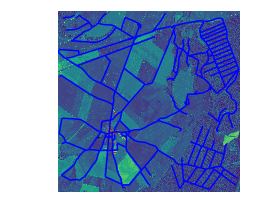

In [99]:
get_ipython().magic(u'matplotlib inline')
save_path = 'D:/allegoria/topo_ortho/cotedor/labels_png/'
my_dpi=300

with rasterio.open(image_files[222]) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'epsg:2154', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

raster = rasterio.open(image_files[222])

name = image_files[i][-36:]
name_wpath = save_path + name[1:-4] + '.png'

bb_box = geom['coordinates']
polygon_bbox = Polygon(bb_box[0])

coordinates = bb_box[0]
x_width, y_width =  (coordinates[2][0]-coordinates[0][0])*2, (coordinates[0][1]-coordinates[1][1])*2

# shapefiles
sg_roads = all_roads[all_roads.geometry.within(polygon_bbox)] #extract segments of roads
sg_houses = all_buildings[all_buildings.geometry.within(polygon_bbox)] #extract segments of buildings
sg_water = data_water[data_water.geometry.within(polygon_bbox)] #extract segments of water
sg_sport = data_sport[data_sport.geometry.within(polygon_bbox)] #extract segments of sport  things


fig, ax = plt.subplots(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)))
rasterio.plot.show(raster, ax=ax)
sg_roads.plot(ax=ax, color='blue', linewidth=0.12)
sg_houses.plot(ax=ax, color='red')
sg_water.plot(ax=ax, color ='green')
sg_sport.plot(ax=ax, color ='black')
plt.axis('off')
plt.savefig(name_wpath, type="png", dpi= float(my_dpi) * 10)


# sg_houses.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='r', ax = ax)
# sg_water.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='g', ax=ax)
# sg_sport.plot(figsize=(x_width/float(10*my_dpi), y_width/float(10*my_dpi)), color ='k', ax = ax)
# # ax.set_xlim([coordinates[0][0],coordinates[2][0]])
# # ax.set_ylim([coordinates[1][1],coordinates[0][1]])
# # 
# # plt.autoscale(False)   
# # ax.axes.get_xaxis().set_visible(False)
# # ax.axes.get_yaxis().set_visible(False)



In [ ]:
# function to get an image, and go through it with a given stride, saving patches
#def tiles_from_image:
raster = rasterio.open("D:/allegoria/datasets_alegoria/BD/BD_ortho/cotedor/BDORTHO_2-0_RVB-0M50_JP2-E080_LAMB93_D021_2017-01-01/BDORTHO/1_DONNEES_LIVRAISON_2018-01-00368/BDO_RVB_0M50_JP2-E080_LAMB93_D21-2017/21-2017-0785-6720-LA93-0M50-E080.jp2")
H,W = raster.shape
for height in range(0, H-512, 512):
    for width in range(0, W-512, 512):
        cropped_image = image[height:height+512, width:width+512]
        if path is not None:
            new_path = path + str(index).zfill(2) + name_indx
            io.imsave(new_path, cropped_image)


        cropped_images[0,:,:,:] = cropped_image
        index +=1
return cropped_images

In [86]:
#save image as a normal TIF
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
name = 'test'

with rasterio.open("D:/allegoria/datasets_alegoria/BD/BD_ortho/cotedor/BDORTHO_2-0_RVB-0M50_JP2-E080_LAMB93_D021_2017-01-01/BDORTHO/1_DONNEES_LIVRAISON_2018-01-00368/BDO_RVB_0M50_JP2-E080_LAMB93_D21-2017/21-2017-0865-6710-LA93-0M50-E080.JP2") as src:
    src_transform = src.transform

    # Zoom out by a factor of 2 from the center of the source
    # dataset. The destination transform is the product of the
    # source transform, a translation down and to the right, and
    # a scaling.
    dst_transform = src_transform*A.translation(
    -src.width/2.0, -src.height/2.0)*A.scale(2.0)

    data = src.read()

    kwargs = src.meta
    kwargs['driver'] = 'GTiff'
    kwargs['transform'] = dst_transform
    kwargs['crs'] ='epsg:2154'
    print(kwargs)

    with rasterio.open(('D:/allegoria/topo_ortho/cotedor/imgs_tif/'+name+'.tif'), 'w', **kwargs) as dst:
        dst.write(data, indexes=(1,2,3))




{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10000, 'height': 10000, 'count': 3, 'crs': 'epsg:2154', 'transform': Affine(1.0, 0.0, 862500.0,
       0.0, -1.0, 6712500.0)}


In [67]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
for i in range(5,8): # range - number of images
    name = image_files[i][-36:]
    print(name)
    with rasterio.open(image_files[i]) as src:
    # Read the dataset's valid data mask as a ndarray.
            dst_crs='epsg:2154'
            
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height   })

            kwargs['driver'] = 'GTiff' # change this one
            data = src.read()
   

            with rasterio.open(('D:/allegoria/topo_ortho/cotedor/'+name[1:-4]+'.tif'), 'w', **kwargs) as dst:
                 for i, band in enumerate(data, 1):
                    dest = np.zeros_like(band)
                    reproject(
                        source=band,
                        destination=dest,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                    dst.write(dest, indexes=i)

21-2017-0780-6700-LA93-0M50-E080.jp2
21-2017-0780-6705-LA93-0M50-E080.jp2
21-2017-0780-6710-LA93-0M50-E080.jp2
